"Real-time Facial Emotion Recognition with Music Recommendations"

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2
import os
from sklearn.model_selection import train_test_split

In [38]:
# Define paths
train_dir = "/Users/krishnadhiman/Downloads/archive/train"
test_dir = "/Users/krishnadhiman/Downloads/archive/test"

In [40]:
# Label names mapping
label_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
label_map = {label: index for index, label in enumerate(label_names)}

In [42]:
# Load the data
def load_data(data_dir, img_size=(48, 48)):
    images = []
    labels = []
    
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:  # Check if the image was loaded successfully
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    
                    if label in label_map:
                        labels.append(label_map[label])
                    else:
                        print(f"Warning: Label '{label}' not found in label map.")
                else:
                    print(f"Warning: Image '{img_path}' could not be loaded.")
    
    images = np.array(images)
    labels = np.array(labels)
    
    images = images.astype('float32') / 255.0
    images = np.expand_dims(images, axis=-1)
    labels = to_categorical(labels, num_classes=len(label_names))
    
    return images, labels

In [44]:
# Load the dataset
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

In [45]:
# Split the training data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [46]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [47]:
# Model Architecture - Increase depth and filters
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(len(label_names), activation='softmax')
])

In [48]:
# Compile the model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [49]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [50]:
from sklearn.utils.class_weight import compute_class_weight

# If train_labels are one-hot encoded, convert them to class indices
train_labels_indices = np.argmax(train_labels, axis=1)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_indices), y=train_labels_indices)
class_weight_dict = dict(enumerate(class_weights))

In [51]:
# Fit the model with the augmented data
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=100,
    validation_data=(val_images, val_labels),
    callbacks=[early_stopping, lr_reduction, model_checkpoint]
)

Epoch 1/100


/Users/krishnadhiman/Downloads/AIML project/tfvenv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-01-09 11:34:27.789590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2270 - loss: 2.6370
Epoch 1: val_loss improved from inf to 2.52632, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.2271 - loss: 2.6361 - val_accuracy: 0.2501 - val_loss: 2.5263 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2897 - loss: 2.2387
Epoch 2: val_loss improved from 2.52632 to 2.17914, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.2897 - loss: 2.2386 - val_accuracy: 0.3170 - val_loss: 2.1791 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3375 - loss: 2.0314
Epoch 3: val_loss improved from 2.17914 to 1.87798, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.3375 - loss: 2.0313 - val_accuracy: 0.3884 - val_loss: 1.8780 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.

In [52]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7038 - loss: 0.9220
Test accuracy: 0.6219002604484558
Test loss: 1.1313292980194092


In [53]:
# Save the model
model.save('facial_expression_model.keras')

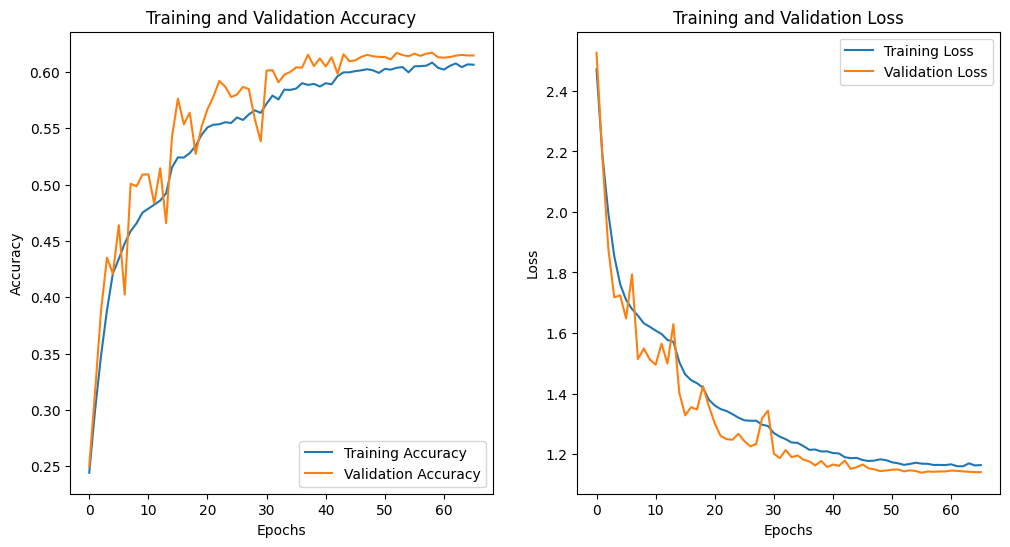

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [62]:
# Confusion Matrix
test_predictions = np.argmax(model.predict(test_images), axis=-1)
test_labels_true = np.argmax(test_labels, axis=-1)

cm = confusion_matrix(test_labels_true, test_predictions)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


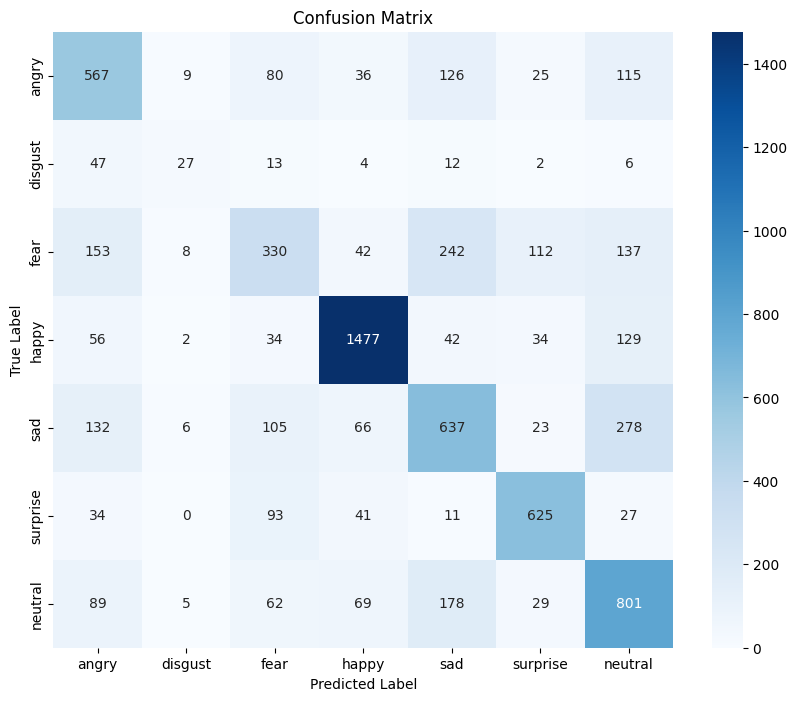

In [63]:
# Plot Confusion Matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute classification metrics
accuracy = accuracy_score(test_labels_true, test_predictions)
precision = precision_score(test_labels_true, test_predictions, average='weighted')
recall = recall_score(test_labels_true, test_predictions, average='weighted')
f1 = f1_score(test_labels_true, test_predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6219
Precision: 0.6195
Recall: 0.6219
F1 Score: 0.6172


In [70]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(test_labels_true, test_predictions, target_names=label_names)
print(report)

              precision    recall  f1-score   support

       angry       0.53      0.59      0.56       958
     disgust       0.47      0.24      0.32       111
        fear       0.46      0.32      0.38      1024
       happy       0.85      0.83      0.84      1774
         sad       0.51      0.51      0.51      1247
    surprise       0.74      0.75      0.74       831
     neutral       0.54      0.65      0.59      1233

    accuracy                           0.62      7178
   macro avg       0.58      0.56      0.56      7178
weighted avg       0.62      0.62      0.62      7178



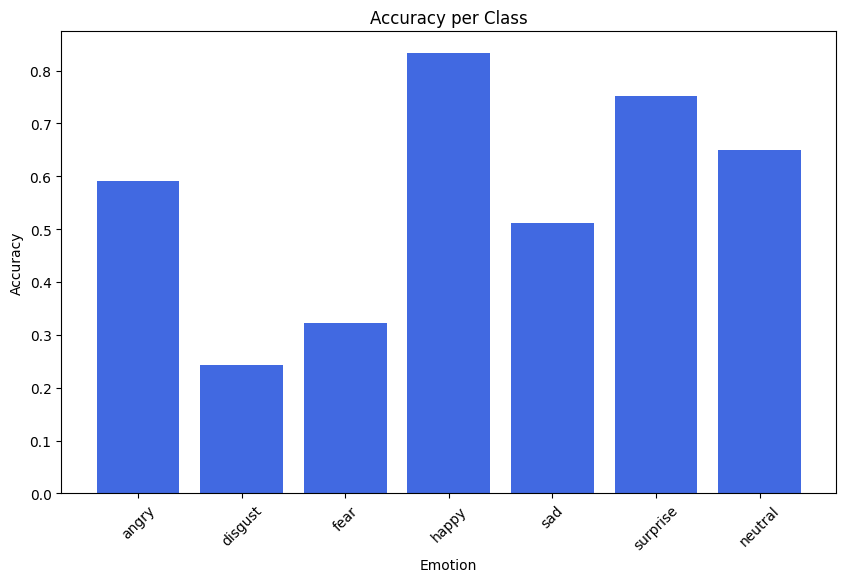

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Calculate accuracy per class
class_accuracies = np.diag(cm) / np.sum(cm, axis=1)
plt.figure(figsize=(10, 6))
plt.bar(label_names, class_accuracies, color='royalblue')
plt.title('Accuracy per Class')
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


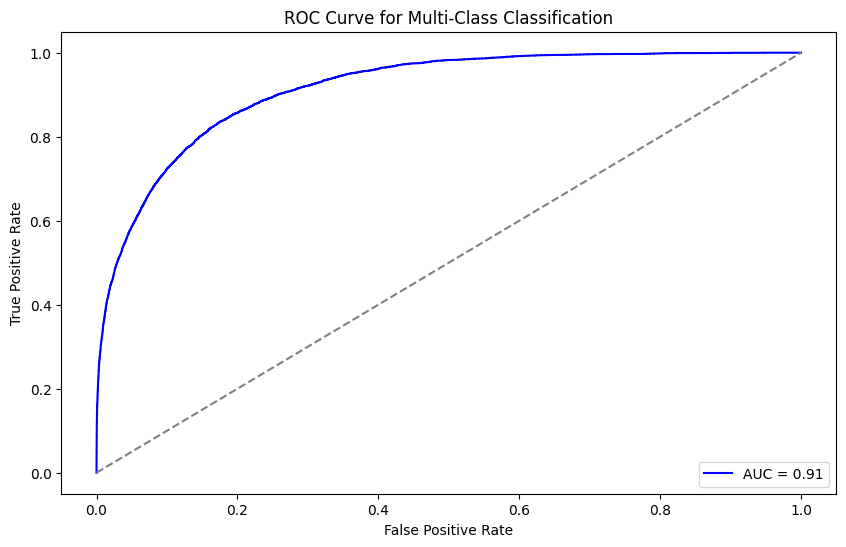

In [80]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the labels for multi-class ROC
test_labels_bin = label_binarize(test_labels_true, classes=np.arange(len(label_names)))

# Get the predicted probabilities for each class
y_pred_probs = model.predict(test_images)

# Compute ROC curve and AUC for each class
fpr, tpr, _ = roc_curve(test_labels_bin.ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [5]:
import cv2
import numpy as np
import pyttsx3
import webbrowser
import time
from keras.models import load_model
import random

In [6]:
# Initialize pyttsx3 for speech output
engine = pyttsx3.init()

In [7]:
# Load the emotion detection model 
emotion_model = load_model('facial_expression_model.keras')

2025-01-09 12:52:41.951793: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-09 12:52:41.951805: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-09 12:52:41.951808: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-09 12:52:41.952110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-09 12:52:41.952121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
# Emotion labels based on the model 
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [9]:
emotion_youtube = {
    'Angry': [
        'https://www.youtube.com/watch?v=-Yd1iOsreK0',  # Beat Me: By Above Envy
        'https://www.youtube.com/watch?v=YHs7ju2KzDs',  # No Filter - Neffex
        'https://www.youtube.com/watch?v=q8IWMnrXbG0',  # Main Nai Tuttna - Attack
        'https://www.youtube.com/watch?v=0gK1SHLtaOo',  # MILA TOH MAREGA
        'https://www.youtube.com/watch?v=Ax0G_P2dSBw',  # Zinda - Bhaag Milkha Bhaag
        'https://www.youtube.com/watch?v=9iIX4PBplAY',  # Kar Har Maidaan Fateh - Sanju
        'https://www.youtube.com/watch?v=abiL84EAWSY',  # Sultan Title Track
        'https://www.youtube.com/watch?v=h6aGikIL-I4'   # Get Ready to Fight - Baaghi
    ],
    'Happy': [
        'https://www.youtube.com/watch?v=fdubeMFwuGs',  # Ilahi
        'https://www.youtube.com/watch?v=KWCLOpaZeLc',  # Tumse Hi Tumse
        'https://www.youtube.com/watch?v=jCEdTq3j-0U',  # Gallan Goodiyan
        'https://www.youtube.com/watch?v=AEIVhBS6baE',  # Pritam - Gerua
        'https://www.youtube.com/watch?v=OulN7vTDq1I',  # DJ Wale Babu
        'https://www.youtube.com/watch?v=WuMWwPHTSoY',  # Dil Dhadakne Do - Zindagi Na Milegi Dobara
        'https://www.youtube.com/watch?v=1YBl3Zbt80A',  # Badri Ki Dulhania
        'https://www.youtube.com/watch?v=HgIW7P4dsXU'   # Nachde Ne Saare - Baar Baar Dekho
    ],
    'Sad': [
        'https://www.youtube.com/watch?v=PVxc5mIHVuQ',  # Pachtaoge
        'https://www.youtube.com/watch?v=_iktURk0X-A',  # Phir Bhi Tumko Chaahunga
        'https://www.youtube.com/watch?v=2JBYnvUlAEcE', # Dhokha Song
        'https://www.youtube.com/watch?v=xRb8hxwN5zc',  # Kal Ho Naa Ho
        'https://www.youtube.com/watch?v=EatzcaVJRMs',  # Tera Yaar Hoon Main
        'https://www.youtube.com/watch?v=IJq0yyWug1k',  # Tum Hi Ho - Aashiqui 2
        'https://www.youtube.com/watch?v=MJyKN-8UncM',  # Shayad - Love Aaj Kal
        'https://www.youtube.com/watch?v=284Ov7ysmfA'   # Channa Mereya
    ],
    'Neutral': [
        'https://www.youtube.com/watch?v=R4YeD7aoOmU',  # Phir Le Aya Dil
        'https://www.youtube.com/watch?v=SAcpESN_Fk4',  # Dil Diyan Gallan
        'https://www.youtube.com/watch?v=TFr6G5zveS8',  # Lag Jaa Gale
        'https://www.youtube.com/watch?v=po6kjouyxXg',  # Mere Sapno Ki Rani
        'https://www.youtube.com/watch?v=Qdz5n1Xe5Qo',  # Tera Ban Jaunga
        'https://www.youtube.com/watch?v=atVof3pjT-I',  # Kaun Tujhe - MS Dhoni
        'https://www.youtube.com/watch?v=qpIdoaaPa6U',  # Jeene Laga Hoon - Ramaiya Vastavaiya
        'https://www.youtube.com/watch?v=odVptmgIcD0'   # Tum Mile
    ],
    'Surprise': [
        'https://www.youtube.com/watch?v=IFP3Jc5ztgg',  # Tunak Tunak Tun
        'https://www.youtube.com/watch?v=ijGumwamEQU',  # Jumma Chumma
        'https://www.youtube.com/watch?v=LYEqeUr-158',  # Sauda Khara Khara
        'https://www.youtube.com/watch?v=yN21C972fsE',  # Oh Ho Ho Ho - Hindi Medium
        'https://www.youtube.com/watch?v=oCBDl58lBoU',  # Bala - Housefull 4
        'https://www.youtube.com/watch?v=52deq20h6Q4',  # Radha - Student of the Year
        'https://www.youtube.com/watch?v=NTHz9ephYTw',  # Kar Gayi Chull - Kapoor & Sons
        'https://www.youtube.com/watch?v=8LZgzAZ2lpQ'   # Abhi Toh Party Shuru Hui Hai - Khoobsurat
    ],
    'Fear': [
        'https://www.youtube.com/watch?v=g0eO74UmRBs',  # Kal Ho Naa Ho
        'https://www.youtube.com/watch?v=yVImQoGNdTE',  # Yaar Bina
        'https://www.youtube.com/watch?v=iasxMdSu7Jo',  # Jiya Dhadak Dhadak Jaye
        'https://www.youtube.com/watch?v=KzBa4ZKTVjE',  # Naina - Dangal
        'https://www.youtube.com/watch?v=6FURuLYrR_Q',  # Ae Dil Hai Mushkil Title Track
        'https://www.youtube.com/watch?v=hoNb6HuNmU0',  # Khairiyat - Chhichhore
        'https://www.youtube.com/watch?v=-y6_cFZsMJA',  # Zindagi Kaisi Hai Paheli - Anand
        'https://www.youtube.com/watch?v=HsQYlZEtKX4'   # Sandese Aate Hain - Border
    ],
    'Disgust': [
        'https://www.youtube.com/watch?v=MXJCnccDLA0',  # Aaj Blue Hai Paani
        'https://www.youtube.com/watch?v=Jn5hsfbhWx4',  # Munni Badnaam Hui
        'https://www.youtube.com/watch?v=52deq20h6Q4',  # Radha - Student of the Year
        'https://www.youtube.com/watch?v=zE7Pwgl6sLA',  # Fevicol Se - Dabangg 2
        'https://www.youtube.com/watch?v=TITGBTGJZS8',  # Selfie Le Le Re - Bajrangi Bhaijaan
        'https://www.youtube.com/watch?v=p6D8u6lEDjQ',  # Dhinka Chika - Ready
        'https://www.youtube.com/watch?v=sONw3dihCRs',  # Anarkali Disco Chali - Housefull 2
        'https://www.youtube.com/watch?v=ZTmF2v59CtI'   # Sheila Ki Jawani - Tees Maar Khan
    ]
}


In [10]:
def predict_emotion(face_image, threshold=0.7):
    face_image = cv2.resize(face_image, (48, 48))
    face_image = face_image.astype('float32') / 255.0
    face_image = np.expand_dims(face_image, axis=0)
    emotion_prediction = emotion_model.predict(face_image)
    max_index = np.argmax(emotion_prediction[0])
    max_confidence = emotion_prediction[0][max_index]
    
    if max_confidence >= threshold:
        predicted_emotion = emotion_labels[max_index]
        return predicted_emotion, max_confidence
    return None, max_confidence

In [11]:
def speak_emotion(emotion, last_emotion=None):
    if emotion != last_emotion:
        engine.say(f"The detected emotion is {emotion}")
        engine.runAndWait()
    return emotion

In [12]:
cap = cv2.VideoCapture(0)
start_time = time.time()
last_emotion = None

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    detected_emotions = []

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        emotion, confidence = predict_emotion(face)
        
        if emotion:
            detected_emotions.append((emotion, confidence))
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            label = f"{emotion} ({confidence*100:.1f}%)"
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    if len(detected_emotions) > 0:
        recognized_emotion = detected_emotions[0][0]

    cv2.imshow('Emotion Detection', frame)
    if time.time() - start_time > 5:
        break

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

if recognized_emotion:
    last_emotion = speak_emotion(recognized_emotion, last_emotion)
    if recognized_emotion in emotion_youtube:
        selected_video = random.choice(emotion_youtube[recognized_emotion])
        webbrowser.open(selected_video)

print(f"Emotion detected: {recognized_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


2025-01-09 12:52:43.778966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


2025-01-09 12:52:44.352 Python[9128:286638] +[IMKClient subclass]: chose IMKClient_Modern
2025-01-09 12:52:44.352 Python[9128:286638] +[IMKInputSession subclass]: chose IMKInputSession_Modern


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1